In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

energie = pd.read_csv("C:/Users/cosyr/OneDrive/Documents/eco2mix-regional-cons-def.csv", sep = ";")
energie.tail()

,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),TCO Hydraulique (%),TCH Hydraulique (%),TCO Bioénergies (%),TCH Bioénergies (%),Column 30
1980283,93,Provence-Alpes-Côte d'Azur,Données consolidées,2022-05-31,23:30,2022-05-31T23:30:00+02:00,4319.0,665.0,NaN,0.0,...,NaN,0.00,0.00,0.00,0.00,21.02,27.74,4.65,68.60,NaN
1980284,11,Île-de-France,Données consolidées,2022-05-31,23:30,2022-05-31T23:30:00+02:00,6483.0,0.0,NaN,29.0,...,NaN,0.45,22.83,0.00,0.00,0.08,25.00,2.25,44.92,NaN
1980285,76,Occitanie,Données consolidées,2022-05-31,23:30,2022-05-31T23:30:00+02:00,3804.0,0.0,1252.0,13.0,...,47.79,0.34,0.82,0.03,0.04,30.42,21.90,1.81,46.31,NaN
1980286,24,Centre-Val de Loire,Données consolidées,2022-05-31,23:30,2022-05-31T23:30:00+02:00,4814.0,28.0,6822.0,236.0,...,58.66,4.90,16.63,0.00,0.00,0.02,1.09,1.39,76.14,NaN
1980287,44,Grand Est,Données consolidées,2022-05-31,23:30,2022-05-31T23:30:00+02:00,4525.0,1220.0,3724.0,585.0,...,34.42,12.93,14.24,0.00,0.00,24.00,46.99,2.70,47.84,NaN


In [2]:
energie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980288 entries, 0 to 1980287
Data columns (total 32 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Code INSEE région    int64  
 1   Région               object 
 2   Nature               object 
 3   Date                 object 
 4   Heure                object 
 5   Date - Heure         object 
 6   Consommation (MW)    float64
 7   Thermique (MW)       float64
 8   Nucléaire (MW)       float64
 9   Eolien (MW)          float64
 10  Solaire (MW)         float64
 11  Hydraulique (MW)     float64
 12  Pompage (MW)         float64
 13  Bioénergies (MW)     float64
 14  Ech. physiques (MW)  float64
 15  Stockage batterie    float64
 16  Déstockage batterie  float64
 17  Eolien terrestre     float64
 18  Eolien offshore      float64
 19  TCO Thermique (%)    float64
 20  TCH Thermique (%)    float64
 21  TCO Nucléaire (%)    float64
 22  TCH Nucléaire (%)    float64
 23  TCO Eolien (%)       float64
 24

In [3]:
#On convertit en Object la variable Code INSEE région vu qu'il s'agit d'une variable catégorielle.
energie["Code INSEE région"] = energie["Code INSEE région"].astype('object')

In [4]:
def first_infos(energie):

    n_cols = len(energie.columns)
    n_rows = len(energie)
    n_duplicates = energie.duplicated().sum()
    n_na = energie.isna().sum().sum()

    return(n_cols, n_rows, n_duplicates, n_na)

first_infos(energie)

(32, 1980288, 0, 29677346)

In [5]:
def summary(energie):
    table = pd.DataFrame(
        index=energie.columns,
        columns=['type_info', '%_missing_values', 'nb_unique_values'])
    table.loc[:, 'type_info'] = energie.dtypes.values
    table.loc[:, '%_missing_values'] = energie.isna().sum().values / len(energie)
    table.loc[:, 'nb_unique_values'] = energie.nunique().values
    table.loc[:, 'min'] = energie.min()
    table.loc[:, 'max'] = energie.max()

    def get_list_unique_values(energie):
        dict_ = {}
        for col in energie.columns:
            if energie[col].nunique() < 15:
                dict_[col] = list(energie[col].unique())
            else:
                if energie[col].dtypes == "O":
                    dict_[col] = "Too much categories..."
                else:
                    dict_[col] = "Too much values..."
        return pd.DataFrame({'unique_values': dict_.values()},
                            index=energie.columns)

    infos_table_int1 = pd.merge(table,
                                get_list_unique_values(energie),
                                left_index=True,
                                right_index=True)

    def get_mean_mode(energie):
        dict_ = {}
        for col in energie.columns:
            if energie[col].dtypes == "O":
                dict_[col] = energie[col].mode()[0]
            else:
                dict_[col] = energie[col].mean()
        return pd.DataFrame(pd.Series(dict_), columns=["mean_mode_values"])

    infos_table_int2 = pd.merge(infos_table_int1,
                                get_mean_mode(energie),
                                left_index=True,
                                right_index=True)

    def alerts(energie):
        thresh_na = 0.25
        thresh_balance = 0.8
        dict_ = {}
        for col in energie.columns:
            if (energie[col].count() / len(energie)) < thresh_na:
                dict_[col] = "Too much missing values ! "
            elif energie[col].value_counts(
                    normalize=True).values[0] > thresh_balance:
                dict_[col] = "It's imbalanced !"
            else:
                dict_[col] = "Nothing to report"

        return pd.DataFrame(pd.Series(dict_), columns=["flag"])

    infos_table = pd.merge(infos_table_int2,
                           alerts(energie),
                           left_index=True,
                           right_index=True)

    return infos_table

summary(energie)

,type_info,%_missing_values,nb_unique_values,min,max,unique_values,mean_mode_values,flag
Code INSEE région,object,0.000000,12,11,93,"[28, 27, 32, 75, 11, 53, 84, 93, 76, 52, 44, 24]",11,Nothing to report
Région,object,0.000000,12,Auvergne-Rhône-Alpes,Île-de-France,"[Normandie, Bourgogne-Franche-Comté, Hauts-de-...",Auvergne-Rhône-Alpes,Nothing to report
Nature,object,0.000000,2,Données consolidées,Données définitives,"[Données définitives, Données consolidées]",Données définitives,It's imbalanced !
Date,object,0.000000,3438,2013-01-01,2022-05-31,Too much categories...,2013-01-01,Nothing to report
Heure,object,0.000000,48,00:00,23:30,Too much categories...,00:00,Nothing to report
Date - Heure,object,0.000000,165004,2013-01-01T00:00:00+01:00,2022-05-31T23:30:00+02:00,Too much categories...,2013-03-31T03:00:00+02:00,Nothing to report
Consommation (MW),float64,0.000006,13284,720.0,15338.0,Too much values...,4497.514319,Nothing to report
Thermique (MW),float64,0.000006,4022,-83.0,4293.0,Too much values...,378.349195,Nothing to report
Nucléaire (MW),float64,0.416670,13376,-144.0,13632.0,Too much values...,6232.624975,Nothing to report
Eolien (MW),float64,0.000055,4638,-6.0,4900.0,Too much values...,256.430221,Nothing to report


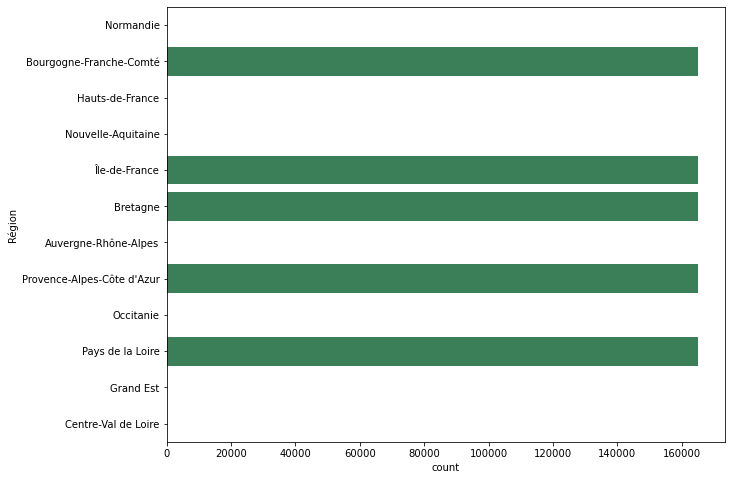

In [6]:
#Gestion des NA - Variable Nucléaire (MW)

nucleaire_na = energie[energie['Nucléaire (MW)'].isna()]

fig = plt.figure(figsize =(10, 8))
sns.countplot(y='Région',data=nucleaire_na, color = "seagreen");

#Remarque : pour la variable "Nucléaire (MW), 5 régions ont des valeurs NaN.
#Elles correspondent aux régions qui ne possèdent pas de réacteur nucléaire sur leur territoire. C'est donc normal que les NaN apparaissent.

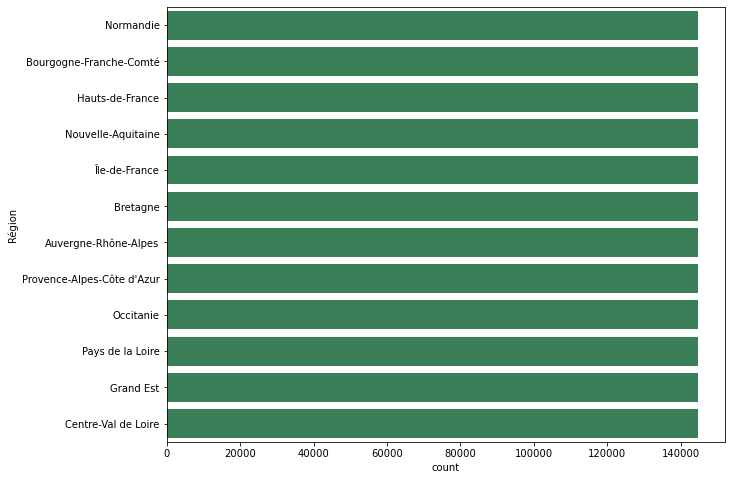

In [7]:
#Gestion des NA - Pompage (MW)
#Constat similaire que ci-dessus

fig = plt.figure(figsize =(10, 8))
sns.countplot(y='Région',data=energie[energie['Pompage (MW)'].isna()], color = "seagreen");

In [8]:
#Gestion des NA - Stockage batterie

energie["Année"] = energie["Date"]
energie["Année"] = energie.Année.apply(lambda Année : Année.split("-")[0])

batt_na = energie[energie['Stockage batterie'].notna()]
batt_na["Année"].unique()

#Nous avons de la data seulement depuis les années 2021 et 2022
#On observe la même chose pour la variable Déstockage batterie

array(['2021', '2022'], dtype=object)

In [9]:
#Gestion des NA - Eolien terrestre

eol_na = energie[energie['Eolien terrestre'].notna()]
eol_na["Année"].unique()

#Nous avons de la data seulement depuis les années 2021 et 2022
#On observe la même chose pour la variable offshore

array(['2021', '2022'], dtype=object)

In [10]:
TCOT = energie[energie['TCH Bioénergies (%)'].notna()]
TCOT["Année"].unique()

array(['2020', '2022'], dtype=object)

In [11]:
#Suppression de la colonne "Column 30" qui n'a pas d'intérêt

energie.drop('Column 30', axis=1, inplace=True)